## Features individually predictive of SL among paralog pairs

**Input**: 
* Bronze standard set of (non-)SL paralog pairs
* All paralog pairs annoated with all features

**Output**:
* Indiv. feature AUCs + avg. precision
* Table S5: bronze standard set of (non-)SL paralog pairs annotated with the 22 features
* Table S6: all features with descriptions and their associated AUC + avg. precision

In [108]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
import scipy.stats as stats

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import textwrap

%load_ext autoreload
%autoreload 1
%aimport graphing_params

import os

get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

# Input
file_annot_pairs = get_local_data_path(['processed','paralog_features'], 'all_features.csv')
file_depmap_pairs = get_local_data_path(['results'], 'bronze_standard_SL_pairs.csv')
file_feature_table = get_local_data_path([], 'feature_table.xlsx')
file_features = get_local_data_path([], 'feature_list.txt')
file_feature_names = get_local_data_path([],'feature_names.txt')

# Outputs
file_feature_aucs = get_local_data_path(['results'], 'indiv_feature_aucs.csv')
file_table_s5 = get_local_data_path(['supplemental_files'], 'Table_S5.csv')
file_table_s6 = get_local_data_path(['supplemental_files'], 'Table_S6.xlsx')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [109]:
paralog_annotations = pd.read_csv(file_annot_pairs)
print('Num annotated pairs:', paralog_annotations.shape[0])
paralog_annotations[:1]

Num annotated pairs: 36648


,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,max_sequence_identity,WGD,...,has_cerevisiae_ortholog,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc
0,A1BG,OSCAR,ENSG00000121410,ENSG00000170909,1,126014,False,0.127273,0.22028,False,...,False,False,False,False,False,False,3,210.95,0.0,False


In [110]:
depmap_pairs = pd.read_csv(file_depmap_pairs, index_col=0)
depmap_pairs = pd.merge(depmap_pairs.drop(columns=['A1_ensembl','A2_ensembl', 'A1_entrez', 'A2_entrez']), 
                        paralog_annotations, on=['A1', 'A2'])
print('Num SL:', sum(depmap_pairs.SL), '/', depmap_pairs.shape[0])
depmap_pairs[:1]

Num SL: 126 / 3634


,A1,A2,SL,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,max_sequence_identity,...,has_cerevisiae_ortholog,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc
0,AAK1,BMP2K,False,ENSG00000115977,ENSG00000138756,22848,55589,True,0.341947,0.413111,...,True,False,False,True,False,False,7,976.25,0.0,False


#### Features

In [111]:
all_features = pd.DataFrame([
    ['min_sequence_identity',                  'sequence',              1,      0],
    ['max_sequence_identity',                  'sequence',              0,      0],
    ['closest',                                'sequence',              1,      0],  
    ['WGD',                                    'sequence',              1,      0], 
    ['family_size',                            'sequence',              1,      0],          
    ['cds_length_ratio',                       'sequence',              1,      0],
    ['shared_domains',                         'sequence',              1,      0], 
    ['has_pombe_ortholog',                     'sequence',              1,      1], 
    ['has_essential_pombe_ortholog',           'sequence',              1,      1],
    ['has_single_essential_pombe_ortholog',    'sequence',              0,      1],
    ['has_cerevisiae_ortholog',                'sequence',              1,      1],   
    ['has_essential_cerevisiae_ortholog',      'sequence',              1,      1],
    ['has_single_essential_cerevisiae_ortholog','sequence',             0,      1],
    ['has_ecoli_ortholog',                     'sequence',              0,      0],
    ['conservation_score',                     'sequence',              1,      0],
    ['mean_age',                               'sequence',              1,      0],
    ['either_in_complex',                      'neighborhood',          1,      0],     
    ['either_in_essential_complex',            'neighborhood',          0,      0],     
    ['mean_complex_ceres_score',               'neighborhood',          0,      0],     
    ['mean_complex_essentiality',              'neighborhood',          1,      0],     
    ['mean_percent_essential_in_complex',      'neighborhood',          0,      0],         
    ['colocalisation',                         'neighborhood',          1,      0],         
    ['interact',                               'neighborhood',          1,      0],         
    ['direct',                                 'neighborhood',          0,      0],     
    ['n_total_ppi',                            'neighborhood',          1,      0],     
    ['n_shared_ppi',                           'neighborhood',          0,      0],         
    ['shared_ppi_jaccard_idx',                 'neighborhood',          0,      0],     
    ['fet_ppi_overlap',                        'neighborhood',          1,      0],     
    ['shared_ppi_percent_essential',           'neighborhood',          0,      0],             
    ['shared_ppi_mean_essentiality',           'neighborhood',          1,      0],              
    ['shared_ppi_mean_ceres_score',            'neighborhood',          0,      0],             
    ['gtex_spearman_corr',                     'expression',            1,      0],
    ['gtex_pearson_corr',                      'expression',            0,      0],     
    ['gtex_min_mean_expr',                     'expression',            1,      0],     
    ['gtex_max_mean_expr',                     'expression',            1,      0]  
], columns=['feature','category', 'include', 'yeast'])

print('Num features:', all_features[all_features.include==1].shape[0])
all_features.to_csv(file_features, index=0)
all_features[:1]

Num features: 22


,feature,category,include,yeast
0,min_sequence_identity,sequence,1,0


In [112]:
# Save bronze standard data + feature annotations as Table S2
features = list(all_features[all_features.include==1].feature)
table_s5 = depmap_pairs[['A1','A2','A1_entrez','A2_entrez','SL'] + features]
display(table_s5[:2])
table_s5.to_csv(file_table_s5, index=0)

,A1,A2,A1_entrez,A2_entrez,SL,min_sequence_identity,closest,WGD,family_size,cds_length_ratio,...,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,shared_ppi_mean_essentiality,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,AAK1,BMP2K,22848,55589,False,0.341947,True,False,2,0.827883,...,False,0.0,0.0,False,77.0,21.870252,0.479952,0.261701,6.713555,6.761786
1,ABCA1,ABCA7,19,10347,False,0.498894,False,True,12,0.949160,...,False,0.0,0.0,False,31.0,0.000000,0.000000,0.027520,15.168588,15.825617


In [113]:
# Nice labels for all features - for graphs
feature_name_map = pd.read_csv(file_feature_names, sep='\t')
feature_name_map[:2]

,simple_name,feature,category
0,Sequence Identity,min_sequence_identity,Sequence
1,Max Sequence Identity,max_sequence_identity,Sequence


### ROC-AUC + Avg. Precision for indiv. features

In [114]:
# Each feature tried as positive / negative, retaining the direction providing an AUC > 0.5
def calc_feature_roc_aucs(pairs, features_df):
    feature_aucs = pd.DataFrame(columns=['roc_auc','roc_auc_mean','roc_auc_sem', 'avg_precision',
                                         'avg_precision_mean','avg_precision_sem','category','direction'])
    for idx, row in features_df.iterrows():
        feature = row.feature
        
        # ROCAUC for all pairs, for both pos/neg feature values
        pos_score = roc_auc_score(pairs.SL, pairs[feature])
        neg_score = roc_auc_score(pairs.SL, -pairs[feature])
        
        # Want to test 10 random splits of the data
        cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10, random_state=11)
        roc_aucs = []; APs = []
        
        # Use pos or neg feature values, depending on higher ROCAUC
        if pos_score > neg_score:
            roc_auc = pos_score
            direction = '+'
            avg_precision = average_precision_score(pairs.SL, pairs[feature])
            for train_idx, test_idx in cv.split(pairs[feature], pairs.SL): 
                roc_aucs.append(roc_auc_score(pairs.iloc[test_idx].SL, pairs.iloc[test_idx][feature]))
                APs.append(average_precision_score(pairs.iloc[test_idx].SL, pairs.iloc[test_idx][feature]))
        else:
            roc_auv = neg_score
            direction = '-'
            avg_precision = average_precision_score(pairs.SL, -pairs[feature])
            for train_idx, test_idx in cv.split(pairs[feature], pairs.SL):
                roc_aucs.append(roc_auc_score(pairs.iloc[test_idx].SL, -pairs.iloc[test_idx][feature]))
                APs.append(average_precision_score(pairs.iloc[test_idx].SL, -pairs.iloc[test_idx][feature]))
        
        # Also calculate the standard error of the mean for ROCAUC and AP
        feature_aucs.loc[feature] = [roc_auc, np.mean(roc_aucs), stats.sem(roc_aucs), 
                                     avg_precision, np.mean(APs), stats.sem(APs), row.category, direction]
    
    feature_aucs = feature_aucs.reset_index().rename(columns={'index':'feature'})
    return feature_aucs

In [115]:
feature_aucs = calc_feature_roc_aucs(depmap_pairs, all_features[(all_features.include==1) | (all_features.yeast==1)])
print('Max AUC: %.3f, mean: %.3f' % (feature_aucs['roc_auc'].max(), feature_aucs['roc_auc'].mean()))
feature_aucs[:2]

Max AUC: 0.731, mean: 0.640


,feature,roc_auc,roc_auc_mean,roc_auc_sem,avg_precision,avg_precision_mean,avg_precision_sem,category,direction
0,min_sequence_identity,0.731492,0.731447,0.006940,0.097999,0.105871,0.003379,sequence,+
1,closest,0.692745,0.692712,0.005917,0.065845,0.066571,0.001482,sequence,+


In [116]:
feature_aucs.to_csv(file_feature_aucs)

In [117]:
# Save feature AUCs in feature table as Table S3
feature_table = pd.read_excel(file_feature_table)
df = pd.merge(feature_table, feature_aucs[['feature','roc_auc', 'avg_precision']].rename(columns={'feature':'Feature'}))
table_s6 = df.rename(columns={'roc_auc':'ROC AUC', 'avg_precision':'Avg. Precision'})
display(table_s6[:2])
table_s6.to_excel(file_table_s6, index=0)

,Simple Name,Feature,Category,Description,Source,ROC AUC,Avg. Precision
0,Sequence Identity,min_sequence_identity,Sequence,The minimum of: the percent of A1's protein-co...,Ensembl,0.731492,0.097999
1,Closest Paralog,closest,Sequence,Whether A1 and A2 are each other's closest par...,Ensembl,0.692745,0.065845


#### Draw indiv feature AUC/AP graph

In [118]:
def draw_feature_auc_chart(feature_aucs, axes, color_dict, with_error=True, xlim=0.752, xlim2=0.11):
    # ROC-AUC
    sns.barplot(x='roc_auc', y='feature', hue='category', data=feature_aucs, ax=axes[0], dodge=False,
                palette=list(color_dict.values()), hue_order=list(color_dict.keys()), saturation=1)
    if with_error:
        axes[0].errorbar(y=feature_aucs.feature, x=feature_aucs.roc_auc, xerr=feature_aucs.roc_auc_sem, 
                         fmt='none', color='black', linewidth=0.8, capsize=0)
    # AP
    sns.pointplot(x='avg_precision', y='feature', hue='category', data=feature_aucs, ax=axes[1], dodge=False,
                  join=False, palette=list(color_dict.values()), hue_order=list(color_dict.keys()), saturation=1, 
                  scale=1.1, ci=None)
    if with_error:
        axes[1].errorbar(y=feature_aucs.feature, x=feature_aucs.avg_precision, xerr=feature_aucs.avg_precision_sem, 
                         fmt='none', color=[color_dict[c] for c in feature_aucs.category], linewidth=0.8)
    
    axes[0].grid(axis='x'); axes[1].grid(axis='x')
    axes[0].set_xlim([0.5, xlim])
    axes[0].legend(loc='lower right', fontsize=9, bbox_to_anchor=(1.04,0), markerscale=0.5)
    axes[0].tick_params(axis='y', which='both', length=0)
    axes[0].set_xlabel('ROC AUC'); axes[0].set_ylabel('')
    
    axes[1].set_xlim([0.03, xlim2])
    axes[1].set_ylim([feature_aucs.shape[0]-0.4, -0.6])
    axes[1].legend().remove()
    axes[1].tick_params(axis='y', which='both', length=0)
    axes[1].set_xlabel('Avg. precision'); axes[1].set_ylabel('')

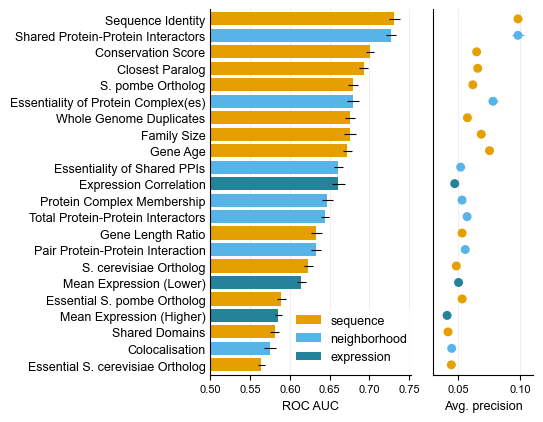

In [119]:
# Merge in feature labels
df = pd.merge(feature_aucs[feature_aucs.feature.isin(all_features[all_features.include==1].feature)], 
              feature_name_map[['feature','simple_name']]).sort_values('roc_auc', ascending=False)
df = df.assign(feature = df.simple_name)

with plt.rc_context({'ytick.labelsize':9}):
    f, axes = plt.subplots(1, 2, figsize=(5.5,4.3), sharey=True, gridspec_kw={'width_ratios': [2, 1]})
    color_dict = {'sequence':'#E69F00', 'neighborhood':'#56B4E9', 'expression':'#248299'}
    draw_feature_auc_chart(df, axes, color_dict)
    plt.tight_layout()
    #plt.savefig("../figures/for_paper/feature_aucs.svg", dpi=300, bbox_inches="tight")

#### PPI & protein complex features

In [120]:
# Some metrics related to the above graph
print('Protein complex essentiality AP=%.3f' % (feature_aucs[feature_aucs.feature=='mean_complex_essentiality'].avg_precision))
print('Shared PPI essentiality AP=%.3f' % (feature_aucs[feature_aucs.feature=='shared_ppi_mean_essentiality'].avg_precision))

print('Total PPI AP=%.3f, AUC=%.3f' % (feature_aucs[feature_aucs.feature=='n_total_ppi'].avg_precision,
                                       feature_aucs[feature_aucs.feature=='n_total_ppi'].roc_auc))
print('Shared PPI AP=%.3f, AUC=%.3f' % (feature_aucs[feature_aucs.feature=='fet_ppi_overlap'].avg_precision,
                                       feature_aucs[feature_aucs.feature=='fet_ppi_overlap'].roc_auc))

Protein complex essentiality AP=0.078
Shared PPI essentiality AP=0.052
Total PPI AP=0.057, AUC=0.644
Shared PPI AP=0.098, AUC=0.727


#### Yeast ortholog features
To compare single essential vs. any essential yeast ortholog

In [121]:
print('AP pombe ortholog=%.3f' % (feature_aucs[feature_aucs.feature=='has_pombe_ortholog'].avg_precision),
      'vs. essential pombe ortholog=%.3f' % (feature_aucs[feature_aucs.feature=='has_essential_pombe_ortholog'].avg_precision))

print('AP cerevisiae ortholog=%.3f' % (feature_aucs[feature_aucs.feature=='has_cerevisiae_ortholog'].avg_precision),
      'vs. essential cerevisiae ortholog=%.3f' % 
      (feature_aucs[feature_aucs.feature=='has_essential_cerevisiae_ortholog'].avg_precision))

AP pombe ortholog=0.062 vs. essential pombe ortholog=0.053
AP cerevisiae ortholog=0.049 vs. essential cerevisiae ortholog=0.045


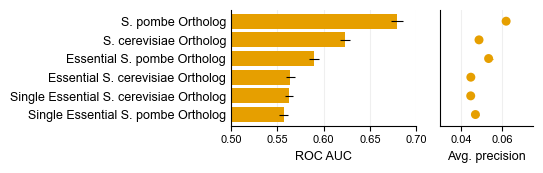

In [122]:
# Filter and merge in feature labels
df = pd.merge(feature_aucs[feature_aucs.feature.isin(all_features[all_features.yeast==1].feature)], 
              feature_name_map[['feature','simple_name']]).sort_values('roc_auc', ascending=False)
df = df.assign(feature = df.simple_name)

with plt.rc_context({'ytick.labelsize':9}):
    f, axes = plt.subplots(1, 2, figsize=(5.5,1.8), sharey=True, gridspec_kw={'width_ratios': [2, 1]})
    draw_feature_auc_chart(df, axes, color_dict={'sequence':'#E69F00'}, xlim=0.7, xlim2=0.075)
    axes[0].legend().remove()
    plt.tight_layout()
    #plt.savefig("../figures/for_paper/yeast_feature_aucs.svg", bbox_inches="tight", dpi=100)

#### Paralog families

Median family size SL pairs: 5.0
Median family size non-SL pairs: 8.0


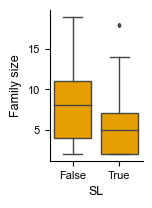

In [123]:
print('Median family size SL pairs:', depmap_pairs[depmap_pairs.SL].family_size.median())
print('Median family size non-SL pairs:', depmap_pairs[~depmap_pairs.SL].family_size.median())

f, ax = plt.subplots(1, 1, figsize=(1.2,2))
sns.boxplot(y=depmap_pairs.family_size, x=depmap_pairs.SL, ax=ax, fliersize=2, color='#E69F00', saturation=1)
_ = ax.set_ylabel('Family size')

### ROC / PR curves for indiv. features

In [124]:
def draw_roc_pr_curves_for_feature(feature, ax1, ax2, color='black', textwidth=10, chance=True):
    feature_values = depmap_pairs[feature]
    if roc_auc_score(depmap_pairs.SL, -feature_values) > roc_auc_score(depmap_pairs.SL, feature_values):
        feature_values = -feature_values
    
    fpr, tpr, _ = roc_curve(depmap_pairs.SL, feature_values)
    precision, recall, _ = precision_recall_curve(depmap_pairs.SL, feature_values)
    precision = precision[:-1]; recall = recall[:-1]

    # Auto-wrap labels based on textwidth
    label = feature_name_map[feature_name_map.feature==feature].simple_name.values[0]
    
    #label1 = label + ' (%.2f)' % (roc_auc_score(depmap_pairs.SL, feature_values))
    label1 = ' \n'.join(textwrap.wrap(label, textwidth, break_long_words=False))
    
    #label2 = label + ' (%.2f)' % (average_precision_score(depmap_pairs.SL, feature_values))
    label2 = ' \n'.join(textwrap.wrap(label, textwidth, break_long_words=False))
    
    ax1.plot(fpr, tpr, label=label1, color=color, lw=1.2)
    ax1.set_ylim([-0.05,1.02]); ax1.set_xlim([-0.05,1.02])
    ax1.set_xlabel('False Positive Rate'); ax1.set_ylabel('True Positive Rate')
    
    if chance:
        ax1.plot([0, 1], [0, 1], linestyle='--', color='black', label='Chance (0.50)')    
        
    ax2.plot(recall, precision, label=label2, color=color, drawstyle="steps-post")
    ax2.set_xlabel('Recall'); ax2.set_ylabel('Precision')
    ax2.set_ylim([-0.05,1.02]); ax2.set_xlim([-0.05,1.02])
    
    if chance:
        no_skill = depmap_pairs[depmap_pairs.SL].shape[0] / depmap_pairs.shape[0]
        ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='Chance')
        ax2.legend(loc="upper right", bbox_to_anchor=(1,1.03))

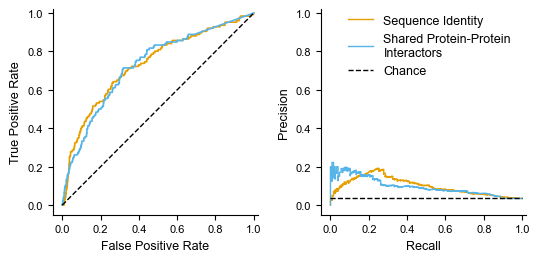

In [94]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.5,2.7))
color_dict = {'sequence':'#E69F00', 'neighborhood':'#56B4E9', 'expression':'#248299'}
draw_roc_pr_curves_for_feature('min_sequence_identity', ax1, ax2, color_dict['sequence'], textwidth=22, chance=False)
draw_roc_pr_curves_for_feature('fet_ppi_overlap', ax1, ax2, color_dict['neighborhood'], textwidth=22)
plt.tight_layout()